<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FX-Carry" data-toc-modified-id="FX-Carry-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FX Carry</a></span></li><li><span><a href="#Performance" data-toc-modified-id="Performance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Performance</a></span><ul class="toc-item"><li><span><a href="#Run-backtest" data-toc-modified-id="Run-backtest-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Run backtest</a></span></li><li><span><a href="#Recent-performance" data-toc-modified-id="Recent-performance-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Recent performance</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# FX Carry

This notebook analyses the FX carry trade (aka forward premium anomaly) where we long high-yielding currencies against low-yielding ones. The uncovered interest rate parity (UIP) suggests that higher-yielding currencies should depreciate on average to offset the benefit of higher interest rates. Empirically however that those currencies tended to weaken much less (or even appreciate) than what the UIP predicts. The FX carry strategy tries to exploit this phenomenon by creating a long-short portfolio in the FX market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest import processing
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy, Weighting
from vivace.backtest.stats import Performance, PerfStats

# Performance
## Run backtest

The `engine` instance below implements a FX carry backtest using FX futures listed on CME. Currencies used in the backtest are EUR, JPY, GBP, CAD, AUD and NZD. Carry is defined as
$$
Carry_t = {\rm log} \left( \frac{F_{1, t}}{F_{2, t}} \right) \cdot annualisationFactor
$$
where $F_{1, t}$ is the 1st contract price, $F_{2, t}$ is the 2nd contract price and $annualisationFactor$ is 12 or 4 if futures are monthly or quarterly respectively to make the log return annual.

The backtest always invests in the front contract and hence the formula above is not technically measuring the carry associated with invested contracts. On the other hand, this can alleviate the issue of potentially using asynchronous prices (settle prices are used to calculate carry) and as long as futures curve is close to linear, it should provide a gooe measure of carry.

Once instruments are ranked by the $Carry$, it goes long top 33% (i.e., 2 instruments at max) and short bottom 33%. Positions are adjusted on a monthly basis.

In [2]:
engine = BacktestEngine(
    strategy=Strategy.DELTA_ONE.value,
    instrument=['EC', 'JY', 'BP', 'CD', 'AD', 'ZB'],
    signal=signal.XSCarryFutureFuture(),
    log_level=logging.WARN,
)
engine.run()

In [3]:
portfolio_return = (engine.calculate_equity_curve(calculate_net=False)
                    .rename('FX carry portfoliot'))

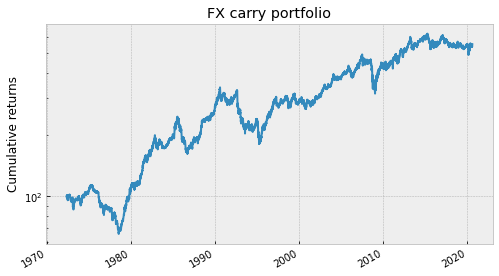

In [4]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.plot(ax=ax, logy=True);
ax.set_title('FX carry portfolio')
ax.set_ylabel('Cumulative returns');

In [5]:
portfolio_return.pipe(Performance).summary()

,FX carry portfoliot
annualised return,0.041228
annualised vol,0.109270
Sharpe ratio,0.377301
max drawdown,0.470048
Calmar ratio,0.087709
skewness,-0.464898
kurtosis,7.528355
worst return,-0.091076
worst 1d return,-0.091076
worst 1w return,-0.114315


## Recent performance

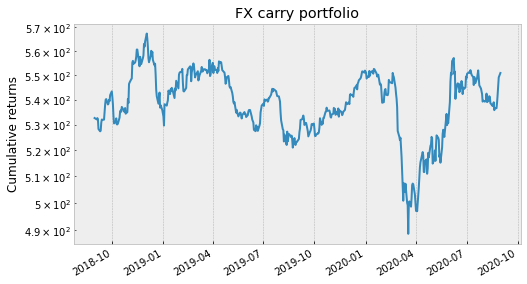

In [6]:
fig, ax = plt.subplots(figsize=(8, 4.5))
portfolio_return.tail(252 * 2).plot(ax=ax, logy=True);
ax.set_title('FX carry portfolio')
ax.set_ylabel('Cumulative returns');

In [7]:
engine.pipeline.pipeline[0].carry.asfreq('m', method='pad')['2016':'2017']

,AD,BP,CD,EC,JY,ZB
2016-01-31,0.011505,-0.001984,-0.000793,-0.012299,-0.009125,0.013092
2016-02-29,0.011505,-0.002380,-0.000397,-0.012894,-0.010315,0.013093
2016-03-31,0.012695,-0.003571,-0.000397,-0.015076,-0.011902,0.011902
2016-04-30,0.011506,-0.002380,0.000000,-0.014481,-0.011902,0.012695
2016-05-31,0.009918,-0.004364,-0.000396,-0.015274,-0.012299,0.012696
2016-06-30,0.009226,-0.005214,0.000000,-0.014841,-0.013838,0.012033
2016-07-31,0.008022,-0.009225,-0.001003,-0.017849,-0.014239,0.010429
2016-08-31,0.006417,-0.010028,-0.001604,-0.018050,-0.016044,0.010428
2016-09-30,0.005678,-0.010139,-0.001825,-0.018048,-0.016425,0.008517
2016-10-31,0.005678,-0.009733,-0.002433,-0.018047,-0.014803,0.007706


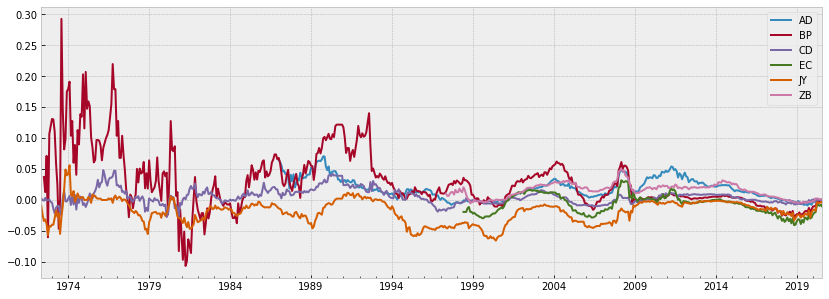

In [8]:
engine.pipeline.pipeline[0].carry.asfreq('m', method='pad').fillna(method='pad').plot(figsize=(14, 5));

# Reference

- Deutsche Bank, 2009, db Currency Return.
- Koijen, R.S., Moskowitz, T.J., Pedersen, L.H. and Vrugt, E.B., 2018. Carry. Journal of Financial Economics, 127(2), pp.197-225.

In [9]:
print(f'Updated: {datetime.utcnow().strftime("%d-%b-%Y %H:%M")}')

Updated: 01-Sep-2020 07:19
